# **Обработка последовательных данных с помощью одномерной сверточной нейронной сети**

# **Реализация одномерной сверточной сети**

In [1]:
# Подготовка данных IMDB

from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
max_len = 500

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=
                        max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
17473536/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


In [4]:
# Обучение и оценка простой одномерной сверточной сети на данных IMDB

from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=Adam(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=30,
                    batch_size=128,
                    validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
____________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


157/157 [==============================] - 4s 23ms/step - loss: 0.7610 - acc: 0.5066 - val_loss: 0.6908 - val_acc: 0.5390
Epoch 2/30
157/157 [==============================] - 3s 21ms/step - loss: 0.6795 - acc: 0.6214 - val_loss: 0.6824 - val_acc: 0.5980
Epoch 3/30
157/157 [==============================] - 3s 20ms/step - loss: 0.6590 - acc: 0.7490 - val_loss: 0.6698 - val_acc: 0.6468
Epoch 4/30
157/157 [==============================] - 3s 20ms/step - loss: 0.6321 - acc: 0.8112 - val_loss: 0.6431 - val_acc: 0.7398
Epoch 5/30
157/157 [==============================] - 3s 20ms/step - loss: 0.5786 - acc: 0.8497 - val_loss: 0.5631 - val_acc: 0.7820
Epoch 6/30
157/157 [==============================] - 3s 21ms/step - loss: 0.4567 - acc: 0.8508 - val_loss: 0.4183 - val_acc: 0.8394
Epoch 7/30
157/157 [==============================] - 3s 21ms/step - loss: 0.3395 - acc: 0.8795 - val_loss: 0.4258 - val_acc: 0.8530
Epoch 8/30
157/157 [==============================] - 3s 21ms/step - loss: 0.297

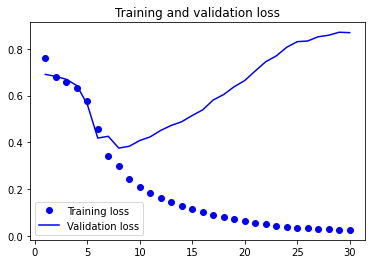

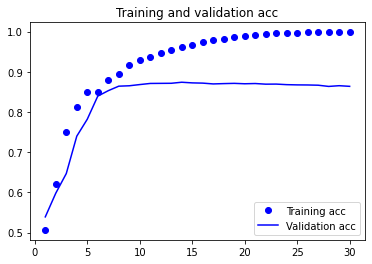

In [5]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.show()

# **Объединение сверточных и рекуррентных сетей для обработки длинных последовательностей**

## ПОдготовка данных Jena

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Обзор набора метеорологических данных Jena
import os
data_dir = '/content/drive/MyDrive/Datasets/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

with open(fname) as f:
  data = f.read()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [9]:
# Преобразование данных
# Столбец с датой и временем исключен

import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [10]:
# Нормализация данных
# Стандартизируем только первые 200000 замеров для обучающей выборки

mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [11]:
# Функция-генератор, возвращающая временные последовательности образцов и их целей

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                    min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                        lookback // step,
                        data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets


In [12]:
lookback = 720 
step = 6       
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=300001,
                    max_index=None,
                    step=step,
                    batch_size=batch_size)

#Сколько раз нужно обратиться к val_gen, чтобы получить проверочный набор данных целиком
val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

##  Обучение и оценка простой одномерной сверточной сети на данных из набора Jena

In [13]:
#  Обучение и оценка простой одномерной сверточной сети на данных из набора Jena

from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=Adam(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 12s 22ms/step - loss: 0.3644 - val_loss: 0.3788
Epoch 2/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2965 - val_loss: 0.3795
Epoch 3/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2679 - val_loss: 0.3740
Epoch 4/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2554 - val_loss: 0.3933
Epoch 5/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2428 - val_loss: 0.3952
Epoch 6/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2307 - val_loss: 0.3894
Epoch 7/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2223 - val_loss: 0.3907
Epoch 8/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2159 - val_loss: 0.3962
Epoch 9/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2105 - val_loss: 0.4026
Epoch 10/20
500/500 [==============================] - 16s 32ms/step - loss: 0.206

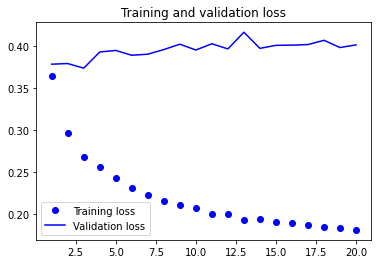

In [14]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## . Подготовка генераторов данных с высоким разрешением для набора данных Jena


In [15]:
step = 3          # Изменился шаг, теперь отбираются данные не за час, а каждые полчаса
lookback = 720
delay = 144       
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)
test_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=300001,
                    max_index=None,
                    step=step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

## Модель, объединяющая одномерную сверточную основу и уровень GRU

In [17]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=Adam(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


500/500 [==============================] - 288s 570ms/step - loss: 0.3255 - val_loss: 0.2858
Epoch 2/10
500/500 [==============================] - 282s 565ms/step - loss: 0.2898 - val_loss: 0.2952
Epoch 3/10
500/500 [==============================] - 281s 562ms/step - loss: 0.2786 - val_loss: 0.2891
Epoch 4/10
500/500 [==============================] - 282s 564ms/step - loss: 0.2684 - val_loss: 0.2767
Epoch 5/10
500/500 [==============================] - 279s 558ms/step - loss: 0.2603 - val_loss: 0.2846
Epoch 6/10
500/500 [==============================] - 282s 563ms/step - loss: 0.2560 - val_loss: 0.2797
Epoch 7/10
500/500 [==============================] - 278s 556ms/step - loss: 0.2499 - val_loss: 0.2834
Epoch 8/10
500/500 [==============================] - 279s 558ms/step - loss: 0.2438 - val_loss: 0.2848
Epoch 9/10
500/500 [==============================] - 276s 553ms/step - loss: 0.2375 - val_loss: 0.3047
Epoch 10/10
500/500 [==============================] - 280s 560ms/step - lo

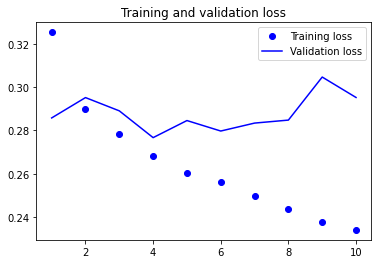

In [18]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()